<a href="https://colab.research.google.com/github/prashantiyaramareddy/MyPython-Stuff/blob/master/Pytorch/Pytorch_Image_Transformer_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Pytorch paper - Vision Transformer



## 0. Get Setup


In [31]:
# For notebook to run with updated API's, we need torch 1.12+ and torchvision 0.13+
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[0]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://download.pytorch.org/whl/cu118
torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [32]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it does not work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from github if it does not work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going modular scripts
  print("[INFO] Couldn't find going_modular or helperfunctions scripts... downloading them from github.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep_learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

### 1. Get Data

In [33]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [34]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [35]:
### 2. Create Datasets and DataLoaders

## 2.1 Prepare transforms for images
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [36]:
## 2.2 Turn image into DataLoader's
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b2989fdd3d0>,
 ['pizza', 'steak', 'sushi'])

In [37]:
## 2.3 Visualize a single image

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

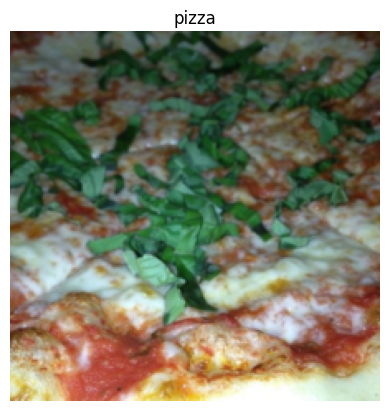

In [38]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

### 4.1 Calculate patch embedding input and output shapes


In [39]:
height = 224
width  = 224
color_channels = 3
patch_size = 16

# Calculate N (number of patches)
number_of_patches = (height * width) / (patch_size * patch_size)
print(f"Number of patches: {number_of_patches}")

Number of patches: 196.0


* Input: The image starts as 2D with size ${H \times W \times C}$.
* Output: The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [40]:
# Input Shape ( this is the size of single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output Shape
embedding_layer_output_shape = (number_of_patches, patch_size * patch_size * color_channels)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196.0, 768))

### 4.2 Turning single image into patches


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

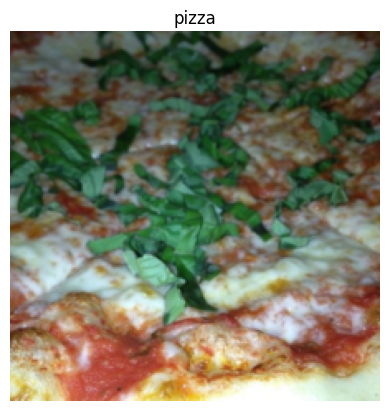

In [41]:
# View  a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [42]:
image.shape

torch.Size([3, 224, 224])

(np.float64(-0.5), np.float64(223.5), np.float64(15.5), np.float64(-0.5))

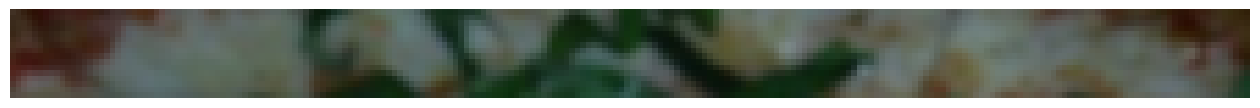

In [43]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0) # Convert the image into color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:, :])
plt.axis(False)

Number of patches: 14.0


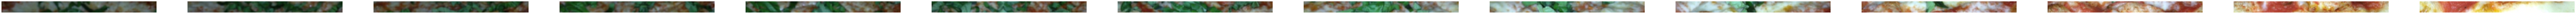

In [44]:
# Set up code to plot top row as patches
img_size = 224
patch_size = 16
number_of_patches = img_size/patch_size
print(f"Number of patches: {number_of_patches}")
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# Create a series of sub plots
fig, axs = plt.subplots(nrows= 1,
                        ncols= img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(img_size, img_size))

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].axis(False)

In [45]:
import matplotlib.pyplot as plt


# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"

print(f"Number of patches: {num_patches}\
      \nNumber of rows: {num_patches}\
      \nNumber of columns: {num_patches}\
      \nImage size: {img_size}\
      \nPatch size: {patch_size}\
      \nTotal Patches : {num_patches ** 2}")

# Create a series of patches
fig, axs = plt.subplots(nrows= int(num_patches),
                        ncols= int(num_patches),
                        sharex=True,
                        sharey=True,
                        figsize=(img_size, img_size))

# Loop through height and width of image
for i, patch_row in enumerate(range(0, img_size, patch_size)):
  for j, patch_col in enumerate(range(0, img_size, patch_size)):
    axs[i, j].imshow(image_permuted[patch_row:patch_row+patch_size, patch_col:patch_col+patch_size])
    axs[i, j].set_ylabel(i+1,
                         rotation = "horizontal",
                         horizontalalignment = "right",
                         verticalalignment = "center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].axis(False)
    axs[i, j].label_outer()

Number of patches: 14.0      
Number of rows: 14.0      
Number of columns: 14.0      
Image size: 224      
Patch size: 16      
Total Patches : 196.0


### 4.3 Creating image patches and turning them into patch embeddings

Perhaps we could create the image patches and image patch embeddings in a single step using 'torch.nn.Conv2d' layer and setting kernel size and stride nn.parameter to 'patch_size'

In [46]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

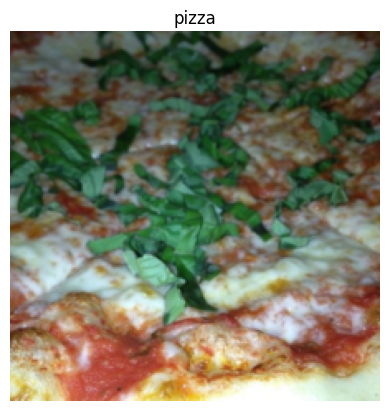

In [47]:
# View Single Image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [48]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Now we have passed our single image to out 'conv2d' layer, it's shape is :

```python
torch.Size([1, 768, 14, 14])
```

In [49]:
image_out_of_conv.requires_grad

True

Random indexes: [331, 297, 73, 732, 83]


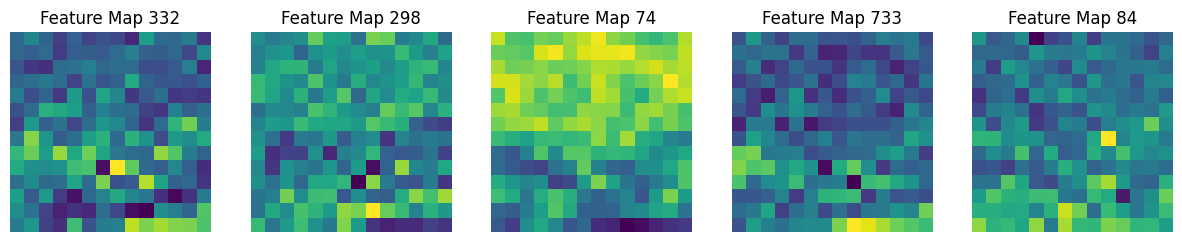

In [50]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Random indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1,
                        ncols=5,
                        sharex=True,
                        sharey=True,
                        figsize=(15, 5))
# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[0, idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set_title(f"Feature Map {idx+1}")
  axs[i].axis(False)

In [51]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad, single_feature_map.shape

(tensor([[[-0.0683, -0.1654, -0.2053, -0.1408, -0.1597, -0.1680, -0.0710,
           -0.1173, -0.1356, -0.1239, -0.2355, -0.2055, -0.1575, -0.0995],
          [-0.1654, -0.1111, -0.1452, -0.1003, -0.1315, -0.0718, -0.1444,
           -0.1423, -0.0664, -0.1348, -0.0928, -0.1121, -0.1760, -0.1698],
          [-0.0925, -0.1096, -0.1205, -0.0966, -0.1726, -0.1368, -0.1803,
           -0.0571, -0.1257, -0.1701, -0.1212, -0.0794, -0.0215, -0.1125],
          [-0.1022, -0.1098, -0.0593, -0.1104, -0.1929, -0.1528, -0.1797,
           -0.0983, -0.1385, -0.1549, -0.1163, -0.1116, -0.1714, -0.1026],
          [-0.0583, -0.1110, -0.1495, -0.2056, -0.0365, -0.2310, -0.2076,
           -0.1637, -0.2047, -0.1627, -0.2091, -0.1457, -0.0650, -0.0973],
          [-0.1590, -0.0731, -0.1418, -0.1750, -0.0995, -0.1754, -0.1974,
           -0.1345, -0.1132, -0.1958, -0.1991, -0.0735, -0.0630, -0.1603],
          [-0.2559, -0.0802, -0.0586, -0.2760, -0.1974, -0.2705, -0.1994,
           -0.1643, -0.2218, -0.

### 4.4 Flattening the patch embedding with `torch.nn.Flatten()`

Right now we got a series of convolutional feature maps(patch embeddings that we want to flatten into a sequence of patch embeddings to satisfy the criteria of the ViT Transformer Encoder.

In [52]:
print(f"{image_out_of_conv.shape} -> [batch_size, embedding_dim, feature_map_height, feature_map_width]")

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]


In [53]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2, end_dim=-1)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image shape after conv2d layer: torch.Size([1, 768, 14, 14])
Image shape after flatten layer: torch.Size([1, 768, 196])


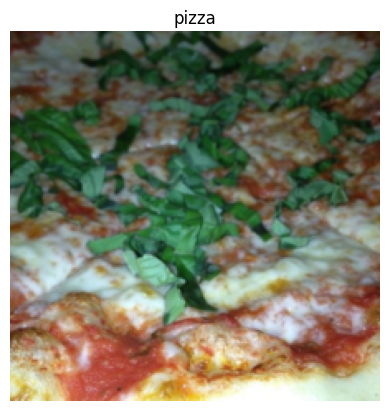

In [54]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into features
image_out_of_conv = conv2d(image.unsqueeze(dim=0))
print(f"Image shape after conv2d layer: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_flatten = flatten_layer(image_out_of_conv)
print(f"Image shape after flatten layer: {image_out_of_flatten.shape}")

In [55]:
# Rearrange output of lfattened layer
image_out_of_flatten = image_out_of_flatten.permute(0, 2, 1)
print(f"{image_out_of_flatten.shape} -> (batch_size, number_of_patches, embedding_dim)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dim)


In [56]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_flatten[:, :, 0]
single_flattened_feature_map, single_flattened_feature_map.shape

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.axis(False)

(np.float64(-0.5), np.float64(195.5), np.float64(0.5), np.float64(-0.5))

In [57]:
# Check the shape of the tensor after flattening and permuting
print(f"Shape of image_out_of_flatten after flattening and permuting: {image_out_of_flatten.shape}")

Shape of image_out_of_flatten after flattening and permuting: torch.Size([1, 196, 768])


### 4.5 Turning the ViT patch embedding layer into a Pytorch module

We want this module to do a few things
1. Create a class called `PatchEmbedding` that inherits from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embeddings dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define ` forward()` that defines the forward computation (e.g., pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding

In [58]:
# 1. Create a class called Patch Embedding
class PatchEmbedding(nn.Module):
  #2. Initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels: int = 3,
               embedding_dim: int = 768,
               patch_size: int = 16):
    super().__init__()

    self.patch_size = patch_size

    # 3. Create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    self.embedding_dim = embedding_dim
    self.patch_size = patch_size

  #3. Create a layer to turn an image into embedding patches using nn.Conv2d()
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Image size must be divisible by patch size, image shape : {image_resolution}, patch size: {self.patch_size}"
    # Pass image through convolutional layer
    x_out = self.patcher(x)
    x_out = self.flatten(x_out)
    x_out = x_out.permute(0, 2, 1)
    return x_out


set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          embedding_dim=768,
                          patch_size=16)
# Pass a single image through patch embedding layer
print(f"Input shape: {image.shape}")
print(f"Output shape: {patchify(image.unsqueeze(dim=0)).shape}")
print(f"Output patch embedding sequence shape : {patchify(image.unsqueeze(dim=0))[:, :, 0]}")

Input shape: torch.Size([3, 224, 224])
Output shape: torch.Size([1, 196, 768])
Output patch embedding sequence shape : tensor([[-0.1843, -0.4147, -0.4036, -0.2555, -0.4407, -0.4407, -0.1278, -0.1615,
         -0.3908, -0.3262, -0.4961, -0.3782, -0.3766, -0.1571, -0.3728, -0.3719,
         -0.4233, -0.2137, -0.1710, -0.2197, -0.1739, -0.1389, -0.0927, -0.2252,
         -0.2252, -0.3398, -0.3500, -0.2556, -0.1993, -0.3646, -0.1971, -0.2892,
         -0.3736, -0.2323, -0.2429, -0.2159, -0.2328, -0.2655, -0.1977, -0.1104,
         -0.3360, -0.3058, -0.1520, -0.2292, -0.3098, -0.2779, -0.2806, -0.4141,
         -0.3446, -0.1700, -0.3314, -0.4503, -0.3855, -0.2777, -0.1924, -0.2481,
         -0.4011, -0.1698, -0.1277, -0.4757, -0.3416, -0.4454, -0.2967, -0.1375,
         -0.2724, -0.3577, -0.5242, -0.2406, -0.2910, -0.3727, -0.3665, -0.2374,
         -0.3602, -0.5085, -0.5260, -0.5029, -0.2342, -0.3674, -0.4018, -0.3773,
         -0.1965, -0.1965, -0.3124, -0.3376, -0.1696, -0.3967, -0.4663,

In [59]:
rand_image_tensor = torch.randn(1,3,224, 224)
rand_image_tensor_bad = torch.randn(1,3,229, 229)
print(f"Input shape: {rand_image_tensor.shape}")
print(f"Output shape: {patchify(rand_image_tensor).shape}")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 196, 768])


### 4.6 Creating the class token embedding
Want to : prepend a learnable class token to the start of the patch embedding

In [60]:
patch_embedded_image = patchify(image.unsqueeze(dim=0))
patch_embedded_image

tensor([[[-0.1843,  0.0504, -0.1396,  ...,  0.1651, -0.0843,  0.0960],
         [-0.4147,  0.1398, -0.1836,  ...,  0.2581, -0.0852,  0.1143],
         [-0.4036,  0.1209, -0.0877,  ...,  0.2932, -0.2059,  0.1394],
         ...,
         [-0.9693,  0.2535, -0.3687,  ...,  0.7273, -0.3212,  0.3231],
         [-0.8425,  0.2291, -0.2905,  ...,  0.6264, -0.3126,  0.2785],
         [-0.9036,  0.2832, -0.2589,  ...,  0.6728, -0.3936,  0.2959]]],
       grad_fn=<PermuteBackward0>)

In [61]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[2]
batch_size, embedding_dim

(1, 768)

In [62]:
# Create a class token embedding as a learnable parameter
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim),
                           requires_grad=True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [63]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)
patch_embedded_image_with_class_embedding

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1843,  0.0504, -0.1396,  ...,  0.1651, -0.0843,  0.0960],
         [-0.4147,  0.1398, -0.1836,  ...,  0.2581, -0.0852,  0.1143],
         ...,
         [-0.9693,  0.2535, -0.3687,  ...,  0.7273, -0.3212,  0.3231],
         [-0.8425,  0.2291, -0.2905,  ...,  0.6264, -0.3126,  0.2785],
         [-0.9036,  0.2832, -0.2589,  ...,  0.6728, -0.3936,  0.2959]]],
       grad_fn=<CatBackward0>)

### 4.7 Creating the position embedding
Want to: create a series of 1D learnable position embeddings and to add them to the sequence of patch embeddings.

In [64]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1843,  0.0504, -0.1396,  ...,  0.1651, -0.0843,  0.0960],
          [-0.4147,  0.1398, -0.1836,  ...,  0.2581, -0.0852,  0.1143],
          ...,
          [-0.9693,  0.2535, -0.3687,  ...,  0.7273, -0.3212,  0.3231],
          [-0.8425,  0.2291, -0.2905,  ...,  0.6264, -0.3126,  0.2785],
          [-0.9036,  0.2832, -0.2589,  ...,  0.6728, -0.3936,  0.2959]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [65]:
# Calculate the N ( number of patches)
number_of_patches = int((height * width) / (patch_size * patch_size))

# Get the embedding dimension
embedding_dim = patch_embedded_image_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,      embedding_dim),
                                  requires_grad=True)
position_embedding


Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)

In [68]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Shape of patch and position embedding: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8157, 1.0504, 0.8604,  ..., 1.1651, 0.9157, 1.0960],
         [0.5853, 1.1398, 0.8164,  ..., 1.2581, 0.9148, 1.1143],
         ...,
         [0.0307, 1.2535, 0.6313,  ..., 1.7273, 0.6788, 1.3231],
         [0.1575, 1.2291, 0.7095,  ..., 1.6264, 0.6874, 1.2785],
         [0.0964, 1.2832, 0.7411,  ..., 1.6728, 0.6064, 1.2959]]],
       grad_fn=<AddBackward0>)
Shape of patch and position embedding: torch.Size([1, 197, 768])
